## 0 .Iniciar Spark en el Colaboratory de Google

In [0]:
# Global data variables

DATA_PATH = "/content/drive/My Drive/"

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

In [6]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
spark = SparkSession.builder.master("local[*]").getOrCreate()



# Workshop de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.

## 1. Cargar Librerias y Funciones

In [0]:
#Librerias

import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
from matplotlib import pyplot as plt
from pyspark.sql import functions as sf # Para concatenar


In [0]:
#Funciones

def remove_tukey_outliers(df, col):
    """
    Returns a new dataframe with outliers removed on column 'col' usting Tukey test
    """
    
    q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
    IQR = q3 - q1
    
    min_thresh = q1 - 1.5 * IQR
    max_thresh = q3 + 1.5 * IQR
    
    df_no_outliers = df.filter(F.col(col).between(min_thresh, max_thresh))
    
    return df_no_outliers

## 2. Cargar Datos

In [0]:
bank = spark.read.csv(DATA_PATH + '/workshop_spark/data/bank-full.csv', sep=';', header=True, inferSchema=True)

### 2.1 Comprobar si el separador ha sido el adecuado

In [196]:
bank.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|             1|         1|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown| no|             1|         1|
| 47| blue-collar|married|  unknow

## 3. Análisis Descriptivo de los Datos

### 3.1 Dimensión de los datos

In [197]:
nRow=bank.count()
nCol= len(bank.columns)
print(f'Hay {nRow} filas y {nCol} columnnas')

Hay 45211 filas y 20 columnnas


### 3.2 Renobrar columnas (aunque  en este caso no sea necesario)

In [198]:
for col in bank.columns:
    bank = bank.withColumnRenamed(col, col.replace('.','_').replace(' ','').lower())
bank.show(1)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
| 58|management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
only showing top 1 row



### 3.3 Nombre de las columnas y tipo de datos

In [199]:
bank.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- extra_info: integer (nullable = true)



#### 3.3.1 Formato de variables

**a. **Observo que los campos** day, month y year **son campos que se refieren a la fecha de la última llamada hecha al cliente. Creo un campo llamado ** Contact_date** a partir de estos tres campos. 

Reviso antes de crear el campo nuevo que lo tipos de datos de estas columnas sean de tipo String. Veo que  los campos  **day** y **year** son enteros, los transformo a string.

In [200]:
bank= bank.withColumn('year', F.col('year').cast('string'))
bank= bank.withColumn('day', F.col('day').cast('string'))
bank.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- extra_info: integer (nullable = true)



In [201]:
bank = bank.withColumn('concat_date',sf.concat(sf.col('day'),sf.lit('/'), sf.col('month'), sf.lit('/'),sf.col('year') ))
bank.show(5)
bank.printSchema()

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+-----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|concat_date|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+-----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1| 5/may/2008|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|             1|         1| 5/may/2008|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown| no| 

**Concat_date** es un string y quiero trasnformarlo a tipo de dato fecha


In [202]:
bank = bank.withColumn('now_concat_date',F.to_date(F.col('concat_date'), 'dd/MMM/yyyy'))
bank = bank.withColumn('date_MMYYYY',F.date_format(F.to_date(F.col('concat_date'), 'dd/MMM/yyyy'), "MMM-yyyy"))
bank=bank.drop('concat_date')
bank.printSchema()
bank.show(3)

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- extra_info: integer (nullable = true)
 |-- now_concat_date: date (nullable = true)
 |-- date_MMYYYY: string (nullable = true)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+

### 3.4 Tratamiento de Nulos

#### 3.4.0 Creo dos dataframes para dividir las variables categoricas y las numéricas

In [0]:
# Creo dataframes de tipo de variables
col_tot= [bank.columns]
col_string = [c for c,t in bank.dtypes if t in ['boolean', 'string']]
col_int= [c for c,t in bank.dtypes if t in ['int', 'double']]
col_int_date= [c for c,t in bank.dtypes if t in ['int', 'double','date']]

#### 3.4.1 Listo el  porcentaje de nulos en todo el dataframe Bank y almaceno en una lista las variables con nulos

In [204]:
#%%time
new_list=[]
for col in bank.columns:    
    n_missing =  bank.filter(F.col(col).isNull()).count()
    perc_missing = 100 * n_missing / nRow   
    if perc_missing > 0  :
      new_list.append(col)      
    print(col, round(perc_missing, 2))
print()
print("*** Estas son las variables del dataset que tienen nulos ***" , new_list)

age 0.0
job 0.0
marital 0.0
education 0.0
default 0.0
balance 0.0
housing 0.0
loan 0.0
contact 0.0
day 0.0
month 0.0
year 0.0
duration 0.0
campaign 0.0
pdays 0.0
previous 0.0
poutcome 0.0
y 0.0
picked_up_call 0.0
extra_info 99.83
now_concat_date 0.0
date_MMYYYY 0.0

*** Estas son las variables del dataset que tienen nulos *** ['extra_info']


#### 3.4.2 Observo que sólo hay una variable que tiene nulos pero al ver el dataset veo que hay registros llamados "Unknown", transformaré estos valores a Null.

**Almaceno en una lista las variables que tengan valores unknown.**

In [205]:
new=[]
for col in col_string:    
    n_missing =  bank.filter(F.col(col)== "unknown").count()    
    perc_missing = 100 * n_missing / nRow   
    if perc_missing > 0  :
      new.append(col)      
    #print(col, round(perc_missing, 2))
print()
print("*** Estas son las variables del dataset que tienen unknown en sus registros ***" , new)


*** Estas son las variables del dataset que tienen unknown en sus registros *** ['job', 'education', 'contact', 'poutcome']


**Usando la lista creada anteriormente, sustituyo el valor unknown por nulos (None)**

In [206]:
for col in new:
  print(col)
  bank = bank.withColumn(col, F.when(bank[col]== "unknown", None).otherwise(bank[col]))
bank.show(3)   

job
education
contact
poutcome
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+---------------+-----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|now_concat_date|date_MMYYYY|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+---------------+-----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|   null|  5|  may|2008|     261|       1|   -1|       0|    null| no|             1|         1|     2008-05-05|   May-2008|
| 44|  technician| single|secondary|     no|     29|    yes|  no|   null|  5|  may|2008|     151|       1|   -1|       0|    null| no|             1|         1|     2008-05-05|   May-2008|
| 33|entrepreneur|marrie

 **Luego reviso de nuevo el número de variables con nulos.**

In [207]:
#%%time
new_list=[]
for col in bank.columns:    
    n_missing =  bank.filter(F.col(col).isNull()).count()
    perc_missing = 100 * n_missing / nRow   
    if perc_missing > 80  :
      new_list.append(col)      
    #print(col, round(perc_missing, 2))
print()
print("*** Estas son las nuevas variables del dataset que tienen nulos ***" , new_list)


*** Estas son las nuevas variables del dataset que tienen nulos *** ['poutcome', 'extra_info']


#### 3.4.3 Borrar Variables con más del 80% de nulos.


**!!! **Antes de borrar,** cacheo** el dataframe para no tener que cargarlo de nuevo más adelante

In [0]:
bank_bef_drop= bank.persist()


En este caso sólo la variables **extra_info**  y **poutcome** cumple esta condición

In [209]:
bank = bank.drop('extra_info', 'poutcome')
bank.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- now_concat_date: date (nullable = true)
 |-- date_MMYYYY: string (nullable = true)



Actualizo los datasets de variables categoricas y numéricas luego de borrar las variables

In [0]:
# Creo dataframes de tipo de variables
col_tot_bd= [bank.columns]
col_string_bd = [c for c,t in bank.dtypes if t in ['boolean', 'string']]
col_int_bd= [c for c,t in bank.dtypes if t in ['int', 'double']]
col_int_date_bd= [c for c,t in bank.dtypes if t in ['int', 'double','date']]

### 3.5 Duplicados

Almaceno un un nuevo dataframe los registro duplicados y comparo la dimensión con el dataframe original. Y observo que no ha cambiado. Es decir, no hay duplicados.

In [211]:
# Dimensión Bank original
nRow=bank.count()
nCol= len(bank.columns)

# Luego de Duplicados
bank_nodup = bank.dropDuplicates()
#bank_nodup.show(2)

# Dimensión
nRow_=bank_nodup.count()
nCol_= len(bank_nodup.columns)
print(f'Antes habia {nRow} filas y {nCol} columnnas y luego de borrar duplicados hay {nRow_} filas y {nCol_} columnnas ')
if nRow==nRow_ :
  print("NO HAY DUPLICADOS")

Antes habia 45211 filas y 20 columnnas y luego de borrar duplicados hay 45211 filas y 20 columnnas 
NO HAY DUPLICADOS


**Como no hay variación en el dataframe original, no borro duplicados en el dataframe  bank_bef_drop**

### 3.6 Transformación de Variables

#### 3.6.1 Transformación binaria de variables categoricas a numéricas. 

**Transformo todas las variables categóricas con 2 categorías a variables binarias.**

In [0]:
# Creo dataframes de tipo de variables
col_tot_= [bank.columns]
col_string = [c for c,t in bank.dtypes if t in ['boolean', 'string']]
col_int= [c for c,t in bank.dtypes if t in ['int', 'double']]
col_int_date= [c for c,t in bank.dtypes if t in ['int', 'double','date']]

**Creo una lista para almacenar las variables que cumplen esta condición.**

In [215]:
lista=[]
for col in col_string:
  n= bank.select(col).distinct().count()
  if n==2:
     lista.append(col)
lista


['default', 'housing', 'loan', 'y']

**Uso la lista para susituir todos los valores e imprimo el listado de columnas para ver si han cambiado el tipo de dato**

In [0]:
for col in lista:
  bank=bank.withColumn(col,F.when(F.col(col)=="yes", 1).otherwise(0))

In [217]:
bank.show(2)
bank.printSchema()

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+---+--------------+---------------+-----------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|  y|picked_up_call|now_concat_date|date_MMYYYY|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+---+--------------+---------------+-----------+
| 58|management|married| tertiary|      0|   2143|      1|   0|   null|  5|  may|2008|     261|       1|   -1|       0|  0|             1|     2008-05-05|   May-2008|
| 44|technician| single|secondary|      0|     29|      1|   0|   null|  5|  may|2008|     151|       1|   -1|       0|  0|             1|     2008-05-05|   May-2008|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+---+--------------+---------------+-----------

### 3.7 Outliers

In [0]:
# Creo dataframes de tipo de variables
col_tot= [bank.columns]
col_string= [c for c,t in bank.dtypes if t in ['boolean', 'string']]
col_int= [c for c,t in bank.dtypes if t in ['int', 'double']]
col_int_date= [c for c,t in bank.dtypes if t in ['int', 'double','date']]

**a) Analizo los outliers de las Variables Numéricas**. 
 Los outliers resultantes los guardo en un dataframe. Y creo otro dataframe sin outliers

In [221]:
for col in col_int:   
  q1, q3 = bank.approxQuantile(col, [0.25, 0.75], 0.01)
  bank_no_outliers = remove_tukey_outliers(bank, col)
  n_bank= bank.count()
  n_out=bank.count() - bank_no_outliers.count()
  bank_out=bank_no_outliers.count()
  porc_out=((n_bank - bank_out)/n_bank)*100
  
  print(f" {col} // registros outliers:: {n_bank} //    registros sin outliers:: {n_out}//     porcentaje outliers::   {porc_out} ")
 

 age // registros outliers:: 45211 //    registros sin outliers:: 381//     porcentaje outliers::   0.8427152684081307 
 default // registros outliers:: 45211 //    registros sin outliers:: 815//     porcentaje outliers::   1.8026586450200173 
 balance // registros outliers:: 45211 //    registros sin outliers:: 4872//     porcentaje outliers::   10.77613855035279 
 housing // registros outliers:: 45211 //    registros sin outliers:: 0//     porcentaje outliers::   0.0 
 loan // registros outliers:: 45211 //    registros sin outliers:: 7244//     porcentaje outliers::   16.022649355245406 
 duration // registros outliers:: 45211 //    registros sin outliers:: 3334//     porcentaje outliers::   7.37431156134569 
 campaign // registros outliers:: 45211 //    registros sin outliers:: 3064//     porcentaje outliers::   6.7771117648359915 
 pdays // registros outliers:: 45211 //    registros sin outliers:: 8257//     porcentaje outliers::   18.263254517705867 
 previous // registros outlier

### Analizo los dataframes despues de transformaciones

In [222]:
# Bank
print("Dimension del df sin borrado de columnas", bank.count(), len(bank.columns))

# Bank antes de borrar columnas
print("Dimension del df con borrado de columnas", bank_bef_drop.count(), len(bank_bef_drop.columns))

# Bank sin outliers
print("Dimension del df sin outliers y con borrado de columnas", bank_no_outliers.count(), len(bank_no_outliers.columns))

# Actualizo dataframes de tipo de variables
col_string = [c for c,t in bank.dtypes if t in ['boolean', 'string']]
col_int= [c for c,t in bank.dtypes if t in ['int', 'double']]



Dimension del df sin borrado de columnas 45211 20
Dimension del df con borrado de columnas 45211 22
Dimension del df sin outliers y con borrado de columnas 45208 20


## 4. Analisis Grafico y Estadístico

### 4.2 Análisis Estadí*stico*

### 4.2.1 Descriptivos

**Realizo descriptvos para los dataframes con y sin outliers**

In [223]:
bank.describe().show()

bank_no_outliers.describe().show()

+-------+------------------+----------+--------+---------+--------------------+------------------+------------------+-------------------+---------+-----------------+-----+------------------+-----------------+-----------------+------------------+------------------+-------------------+--------------------+-----------+
|summary|               age|       job| marital|education|             default|           balance|           housing|               loan|  contact|              day|month|              year|         duration|         campaign|             pdays|          previous|                  y|      picked_up_call|date_MMYYYY|
+-------+------------------+----------+--------+---------+--------------------+------------------+------------------+-------------------+---------+-----------------+-----+------------------+-----------------+-----------------+------------------+------------------+-------------------+--------------------+-----------+
|  count|             45211|     44923|   4521

Y observo que en general la media y la desviación estadar para la mayoria de variables varian muy poco, a excepción de la a variable numérica **picked_up_call**  que luego de borrar los outliers se queda con un sólo valor. 

In [224]:
print("Variable: picked_up_call antes de borrar outliers")
bank.select('picked_up_call').groupBy('picked_up_call').count().show()

print("Variable: picked_up_call despues de borrar outliers")
bank_no_outliers.select('picked_up_call').groupBy('picked_up_call').count().show()

Variable: picked_up_call antes de borrar outliers
+--------------+-----+
|picked_up_call|count|
+--------------+-----+
|             1|45208|
|             0|    3|
+--------------+-----+

Variable: picked_up_call despues de borrar outliers
+--------------+-----+
|picked_up_call|count|
+--------------+-----+
|             1|45208|
+--------------+-----+



Asi que la borro del dataframe y decido seguir usando, como definitivo el dataframe que no incluye los outliers: **bank_no_outliers**.

In [225]:
bank_no_outliers = bank_no_outliers.drop('picked_up_call')
bank_no_outliers.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: integer (nullable = false)
 |-- balance: integer (nullable = true)
 |-- housing: integer (nullable = false)
 |-- loan: integer (nullable = false)
 |-- contact: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- y: integer (nullable = false)
 |-- now_concat_date: date (nullable = true)
 |-- date_MMYYYY: string (nullable = true)



Actualizo los dataframes de variables categoricas y numéricas usando el dataframe  **bank_no_outliers**.

In [0]:
# Creo dataframes de tipo de variables
col_tot_out= [bank_no_outliers.columns]
col_string_out = [c for c,t in bank_no_outliers.dtypes if t in ['boolean', 'string']]
col_string_date_out = [c for c,t in bank_no_outliers.dtypes if t in ['boolean', 'string','date']]
col_int_out= [c for c,t in bank_no_outliers.dtypes if t in ['int', 'double']]
col_int_date_out= [c for c,t in bank_no_outliers.dtypes if t in ['int', 'double','date']]

**Descriptivos usando la variable respuesta**

Comparo la variable y con el conjunto de **variables numéricas**

In [228]:
bank_no_outliers.groupBy('y').agg(F.avg('age'), F.sum('default'), F.avg('balance'),  F.sum('housing'),  F.sum('loan'),  F.avg('duration'),  F.avg('campaign'),  F.avg('pdays'),  F.avg('previous')).show()

+---+------------------+------------+------------------+------------+---------+------------------+------------------+-----------------+------------------+
|  y|          avg(age)|sum(default)|      avg(balance)|sum(housing)|sum(loan)|     avg(duration)|     avg(campaign)|       avg(pdays)|     avg(previous)|
+---+------------------+------------+------------------+------------+---------+------------------+------------------+-----------------+------------------+
|  1|41.664334341906205|          52|1803.5283661119515|        1935|      484| 537.1830559757942|2.1405068078668683|68.68116490166415|1.1700075642965204|
|  0| 40.83867735470942|         763| 1303.689128256513|       23195|     6760|221.17211923847697|2.8463426853707414| 36.4185120240481|0.5019038076152305|
+---+------------------+------------+------------------+------------+---------+------------------+------------------+-----------------+------------------+



In [229]:
bank_no_outliers.groupBy('y','loan').count().sort(F.col('y'). desc()).show()

+---+----+-----+
|  y|loan|count|
+---+----+-----+
|  1|   0| 4804|
|  1|   1|  484|
|  0|   0|33160|
|  0|   1| 6760|
+---+----+-----+



1 - age (numeric)

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown') 

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)


### 4.2.2 Matriz Correlación

In [231]:
corr_matrix = Statistics.corr(bank_no_outliers.select(col_int_out).rdd.map(lambda v: Vectors.dense(v)), 
                              method='pearson')
corr_matrix

array([[ 1.        , -0.01786929,  0.09771663, -0.18544266, -0.01561797,
        -0.0048972 ,  0.00469884, -0.02382914,  0.00126631,  0.02499163],
       [-0.01786929,  1.        , -0.06674167, -0.00603553,  0.07723085,
        -0.01000863,  0.0168243 , -0.02997335, -0.01831785, -0.02241486],
       [ 0.09771663, -0.06674167,  1.        , -0.06873017, -0.08433628,
         0.02145745, -0.01459671,  0.00337083,  0.01659068,  0.0527599 ],
       [-0.18544266, -0.00603553, -0.06873017,  1.        ,  0.04129242,
         0.00519375, -0.02357825,  0.1242515 ,  0.03721829, -0.13914053],
       [-0.01561797,  0.07723085, -0.08433628,  0.04129242,  1.        ,
        -0.01236793,  0.00998844, -0.02273073, -0.01099477, -0.06817185],
       [-0.0048972 , -0.01000863,  0.02145745,  0.00519375, -0.01236793,
         1.        , -0.08464213, -0.00167647,  0.00109052,  0.39441555],
       [ 0.00469884,  0.0168243 , -0.01459671, -0.02357825,  0.00998844,
        -0.08464213,  1.        , -0.08864397

In [234]:
corr_matrix = pd.DataFrame(corr_matrix, columns=col_int_out, index=col_int_out)
corr_matrix

,age,default,balance,housing,loan,duration,campaign,pdays,previous,y
age,1.000000,-0.017869,0.097717,-0.185443,-0.015618,-0.004897,0.004699,-0.023829,0.001266,0.024992
default,-0.017869,1.000000,-0.066742,-0.006036,0.077231,-0.010009,0.016824,-0.029973,-0.018318,-0.022415
balance,0.097717,-0.066742,1.000000,-0.068730,-0.084336,0.021457,-0.014597,0.003371,0.016591,0.052760
housing,-0.185443,-0.006036,-0.068730,1.000000,0.041292,0.005194,-0.023578,0.124252,0.037218,-0.139141
loan,-0.015618,0.077231,-0.084336,0.041292,1.000000,-0.012368,0.009988,-0.022731,-0.010995,-0.068172
duration,-0.004897,-0.010009,0.021457,0.005194,-0.012368,1.000000,-0.084642,-0.001676,0.001091,0.394416
campaign,0.004699,0.016824,-0.014597,-0.023578,0.009988,-0.084642,1.000000,-0.088644,-0.032853,-0.073222
pdays,-0.023829,-0.029973,0.003371,0.124252,-0.022731,-0.001676,-0.088644,1.000000,0.454767,0.103557
previous,0.001266,-0.018318,0.016591,0.037218,-0.010995,0.001091,-0.032853,0.454767,1.000000,0.093237
y,0.024992,-0.022415,0.052760,-0.139141,-0.068172,0.394416,-0.073222,0.103557,0.093237,1.000000


In [235]:
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False,  True,  True,
         True],
       [False, False, False, False, False, False, False, False,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
         True]])

In [236]:
corr_matrix = corr_matrix.mask(mask)
corr_matrix

,age,default,balance,housing,loan,duration,campaign,pdays,previous,y
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,-0.017869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,0.097717,-0.066742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,-0.185443,-0.006036,-0.068730,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,-0.015618,0.077231,-0.084336,0.041292,NaN,NaN,NaN,NaN,NaN,NaN
duration,-0.004897,-0.010009,0.021457,0.005194,-0.012368,NaN,NaN,NaN,NaN,NaN
campaign,0.004699,0.016824,-0.014597,-0.023578,0.009988,-0.084642,NaN,NaN,NaN,NaN
pdays,-0.023829,-0.029973,0.003371,0.124252,-0.022731,-0.001676,-0.088644,NaN,NaN,NaN
previous,0.001266,-0.018318,0.016591,0.037218,-0.010995,0.001091,-0.032853,0.454767,NaN,NaN
y,0.024992,-0.022415,0.052760,-0.139141,-0.068172,0.394416,-0.073222,0.103557,0.093237,NaN


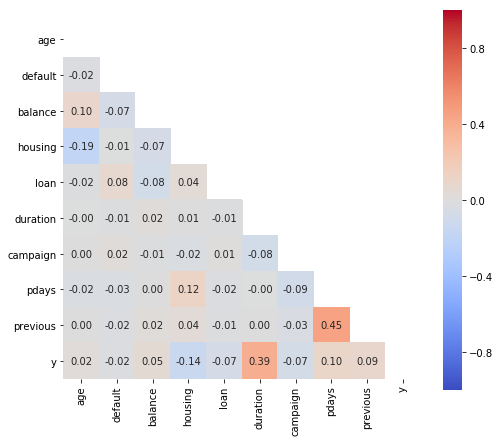

In [237]:
plt.figure(figsize=(8,7))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')

**Columnas altamente correladas**

1) (y - duration) : Contratación de un deposito a plazo - duración de la llamada:: Es de esperarse porque si duration=0 entonces  y='no'.


2) (previous - pdays): Número de contactos realizados antes de la campaña - nº de días que han pasado desde la última llamada hasta el día del nuevo contacto o llamada para esta nueva campaña. 

### 4.2 Análisis Gráfico

**Creo un dataframe de muestra y lo transformo a Pandas**

In [238]:
sample_bank = bank_no_outliers.sample(False, fraction=0.2).toPandas()
sample_bank.head(10)
sample_bank.shape

(9057, 19)

In [0]:
# Actualizo dataframes de tipo de variables

#  Creo el dataframe de Variables Categóricas
list(set(sample_bank.dtypes.tolist()))
var_categorical = sample_bank.select_dtypes(include = ['O'])


#  Creo el dataframe de Variables Numéricas
list(set(sample_bank.dtypes.tolist()))
var_numerical = sample_bank.select_dtypes(include = ['float64', 'int64'])


In [0]:
%matplotlib inline

#### 4.4.1 Histogramas

Observo en los histogramas que la variables respuesta esta desproporciónada.

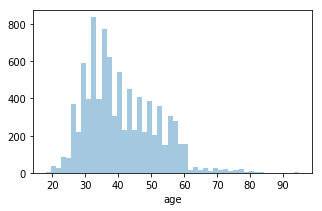

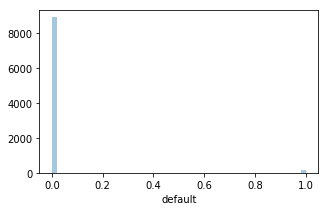

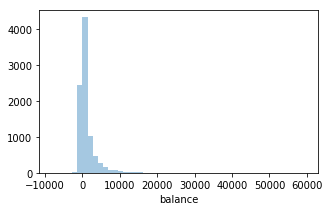

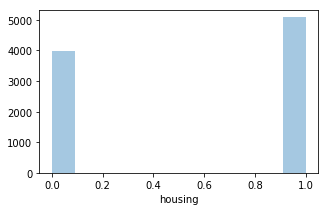

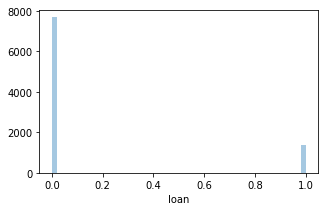

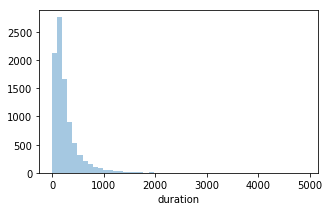

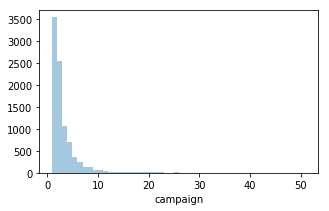

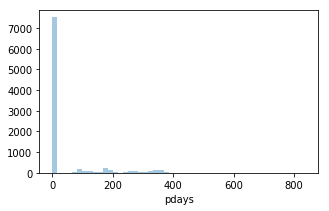

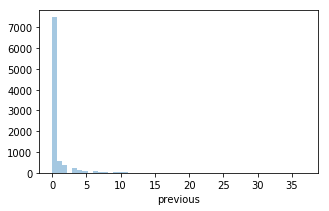

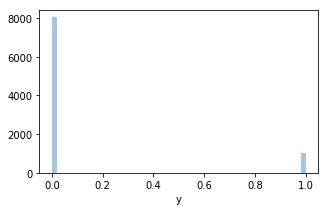

In [241]:
for col in var_numerical.columns: 
  plt.figure(figsize=(5,3))
  sns.distplot(sample_bank[col], kde=False)
  plt.show()

#### 4.4.2 Barplots

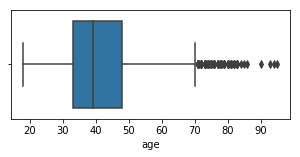

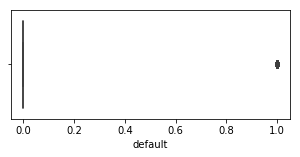

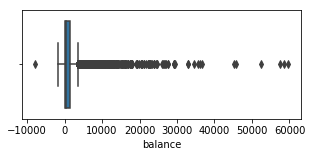

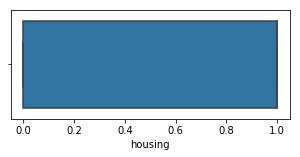

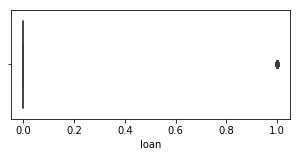

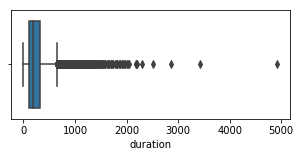

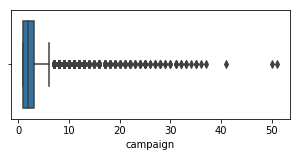

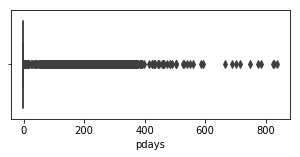

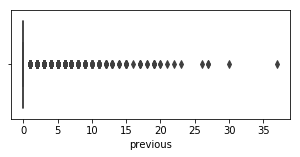

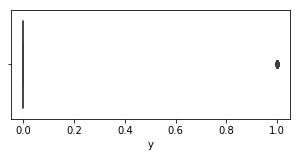

In [242]:
for col in var_numerical.columns: 
  plt.figure(figsize=(5,2))
  sns.boxplot(sample_bank[col], orient='h')

In [0]:
def percentile_based_outlier(data, threshold=98):
    diff = (100 - threshold) / 2
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)
  
col_names= var_numerical.columns
fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):
    x = sample_bank[col_val][:1000]
    sns.distplot(x, ax=ax[i], rug=True, hist=False)
    outliers = x[percentile_based_outlier(x)]       # Esto me crea un dataframe con outliers
    ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    ax[i].set_title('Outlier detection - {}'.format(col_val), fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)

plt.show()

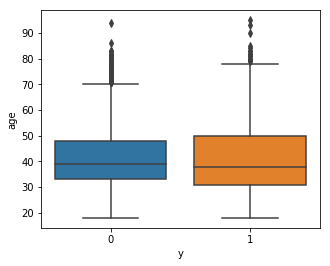

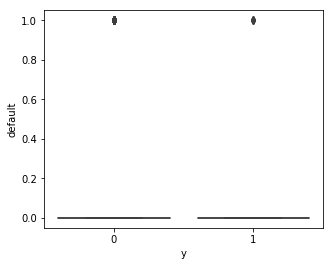

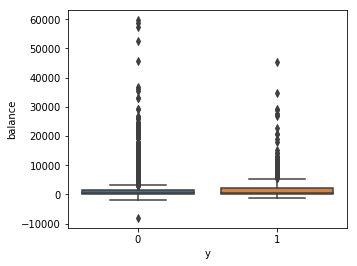

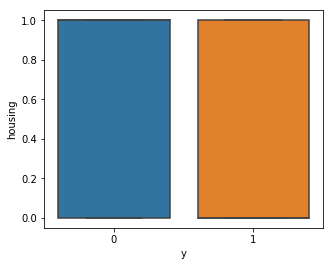

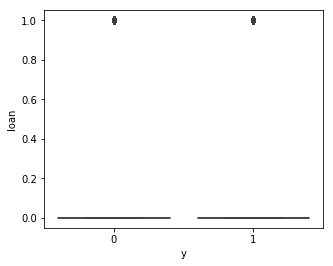

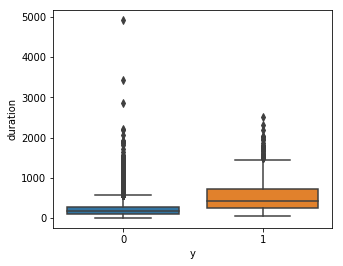

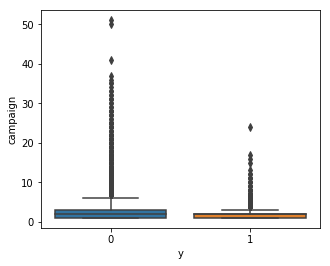

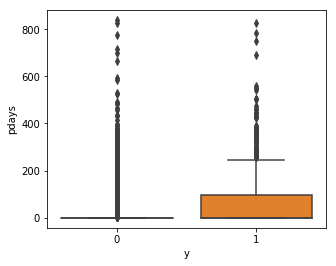

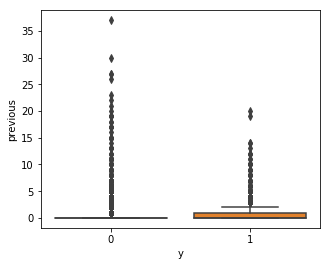

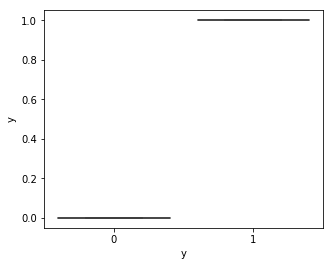

In [243]:
for col in var_numerical.columns: 
  plt.figure(figsize=(5,4))
  sns.boxplot(x='y', y=col, data=sample_bank, orient='v')

In [244]:
bank_no_outliers.groupBy('y','loan').count().sort(F.col('count'). desc()).show()


+---+----+-----+
|  y|loan|count|
+---+----+-----+
|  0|   0|33160|
|  0|   1| 6760|
|  1|   0| 4804|
|  1|   1|  484|
+---+----+-----+



#### 4.4.2 Scatter Plot

In [280]:
Y_date=bank_no_outliers.groupBy('date_MMYYYY').agg(F.count('y')).sort(F.col('date_MMYYYY').asc()).toPandas()
Y_date_p=bank_no_outliers.groupBy('now_concat_date').agg(F.count('y')).sort(F.col('now_concat_date').asc()).toPandas()


,now_concat_date,count(y)
0,2008-05-05,361
1,2008-05-06,405
2,2008-05-07,390
3,2008-05-08,453
4,2008-05-09,429


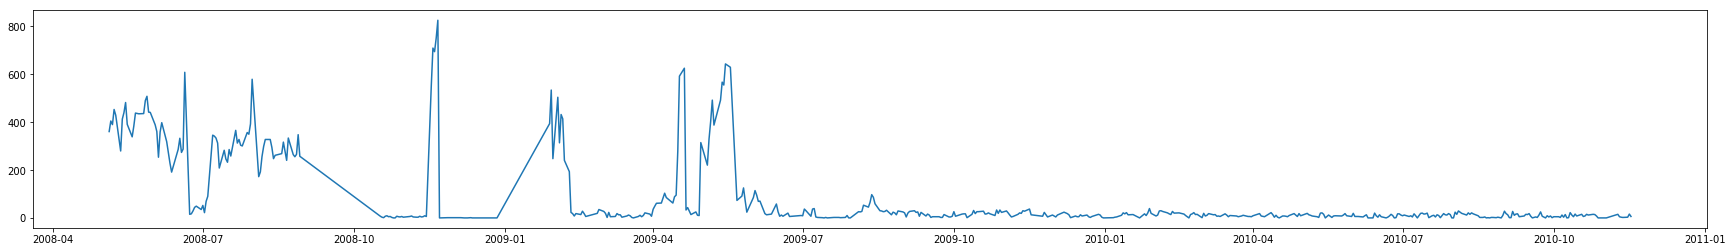

In [283]:
plt.figure(figsize=(30,4))
plt.plot(Y_date_p['now_concat_date'], Y_date_p["count(y)"])

## 5. Balancear el dataframe

**Debido a la desproporción de la variable dependiente y. Decido analizarla y balancear el dataframe de muestra, para obtener la misma proporción de 1's y 0s.**

**Antes del balanceo la proporción de las categorias de la variable dependiente "y" es la siguiente:**

In [170]:
bank_no_outliers.select('y').groupBy('y').count().show()

+---+-----+
|  y|count|
+---+-----+
|  1| 5288|
|  0|39920|
+---+-----+



**Balanceo el dataframe**

In [169]:
balance_sample = bank_no_outliers.sampleBy("y", fractions={0: 0.1, 1: 0.9}, seed=10)

balance_sample.select('y').groupBy('y').count().show()
balance_sample= balance_sample.toPandas()
balance_sample.shape

+---+-----+
|  y|count|
+---+-----+
|  1| 4794|
|  0| 3987|
+---+-----+



(8781, 19)

Actualizo los dataframes categoricos y numéricos

In [0]:
# Actualizo dataframes de tipo de variables

#  Creo el dataframe de Variables Categóricas
list(set(balance_sample.dtypes.tolist()))
var_categorical_bal = balance_sample.select_dtypes(include = ['O'])


#  Creo el dataframe de Variables Numéricas
list(set(balance_sample.dtypes.tolist()))
var_numerical_bal = balance_sample.select_dtypes(include = ['float64', 'int64'])


**Al balancear mejora la correlacion entre el par de variables pdays - previos y  y-duration, pero no aumenta el número de variables correlacionadas con y**

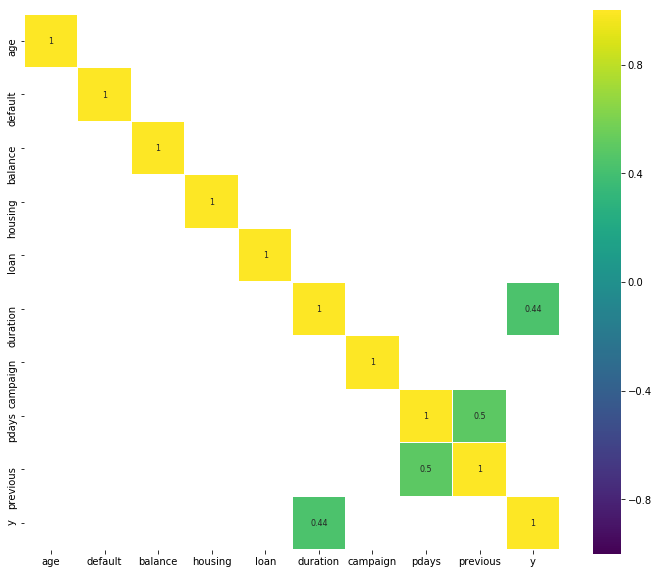

In [172]:
#corr = balance_sample.drop('y', axis=1).corr() 
corr= balance_sample.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [173]:
# Relacion entre dos variables
                       
corr_val= (corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool)).stack().sort_values(ascending=False))     
corr_val

pdays     previous    0.498871
duration  y           0.435151
previous  y           0.149118
pdays     y           0.134789
age       balance     0.116319
housing   loan        0.084329
balance   y           0.076147
default   loan        0.074285
housing   pdays       0.067641
age       y           0.047209
loan      campaign    0.046896
housing   duration    0.044497
balance   previous    0.029146
age       previous    0.028506
housing   campaign    0.016552
balance   duration    0.015235
loan      duration    0.014320
default   housing     0.011894
balance   pdays       0.010480
default   campaign    0.007757
age       pdays       0.007217
default   duration    0.005704
age       duration    0.003132
housing   previous   -0.000177
age       campaign   -0.012394
balance   campaign   -0.022308
age       default    -0.022761
duration  campaign   -0.023201
default   y          -0.031672
loan      previous   -0.034670
duration  previous   -0.034826
default   pdays      -0.036940
age     